# Import library

In [2]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer
import matplotlib.pyplot as plt
import math
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse

from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader

import math
import matplotlib.pyplot as plt
import pandas as pd

from matplotlib.backends.backend_pdf import PdfPages
from PIL import Image
from mpl_toolkits.mplot3d import Axes3D

# Encoding comparison (Nonlinear)

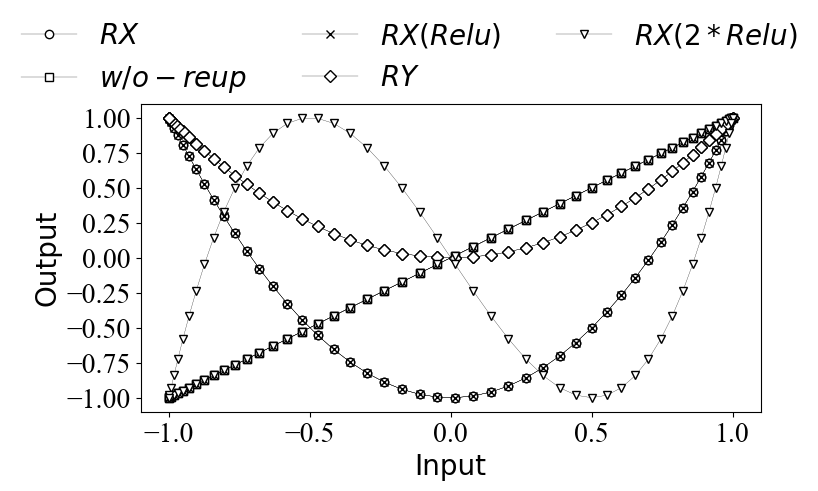

In [3]:
n_qubits = 1
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs):
    qml.RX(inputs, wires=0)
    qml.Identity(wires=0)
    qml.RX(inputs, wires=0)
    return (qml.expval(qml.PauliZ(0)))


@qml.qnode(dev)
def qnode1(inputs):
    qml.RX(inputs, wires=0)
    return (qml.expval(qml.PauliZ(0)))

@qml.qnode(dev)
def qnode2(inputs):
    qml.RX(inputs, wires=0)
    qml.Identity(wires=0)
    return (qml.expval(qml.PauliZ(0)))


@qml.qnode(dev)
def qnode3(inputs, inputs_relu):
    qml.RX(inputs, wires=0)
    qml.Identity(wires=0)
    qml.RX(inputs_relu, wires=0)
    return (qml.expval(qml.PauliZ(0)))


@qml.qnode(dev)
def qnode4(inputs):
    qml.RX(inputs, wires=0)
    qml.Identity(wires=0)
    qml.RY(inputs, wires=0)
    return (qml.expval(qml.PauliZ(0)))


init_input = np.linspace(-math.pi,math.pi,100)
relu_input = np.maximum(0,init_input)
relu_input2 = np.maximum(0,init_input)*2

encode_input = np.zeros(100)
nore_out = np.zeros(100)
reupload_out = np.zeros(100)
rerelu_out = np.zeros(100)
ry_out = np.zeros(100)
rerelu_out2 = np.zeros(100)
for i in range(len(init_input)):
  x1 = qnode1(init_input[i])
  encode_input[i] = x1
  x2 = qnode(init_input[i])
  reupload_out[i] = x2
  x3 = qnode2(init_input[i])
  nore_out[i] = x3
  x4 = qnode3(init_input[i], relu_input[i])
  rerelu_out[i] = x4
  x5 = qnode4(init_input[i])
  ry_out[i] = x5
  x6 = qnode3(init_input[i], relu_input2[i])
  rerelu_out2[i] = x6

a = encode_input.reshape(100, 1)
b = nore_out.reshape(100, 1)
c = reupload_out.reshape(100, 1)
d = rerelu_out.reshape(100, 1)
e = ry_out.reshape(100, 1)
f = rerelu_out2.reshape(100, 1)

final = np.concatenate((a,b),axis=1)
final = np.concatenate((final,c),axis=1)
final = np.concatenate((final,d),axis=1)
final = np.concatenate((final,e),axis=1)
final = np.concatenate((final,f),axis=1)


plt.figure(figsize=(8,4)) 
plt.plot(encode_input, reupload_out, label="$RX$",color="black",linewidth=0.2, marker='o', markerfacecolor="w")
plt.plot(encode_input, nore_out, label="$w/o-reup$",color="black",linewidth=0.2, marker='s', markerfacecolor="w")
plt.plot(encode_input, rerelu_out, label="$RX(Relu)$",color="black",linewidth=0.2, marker='x', markerfacecolor="w")
plt.plot(encode_input, ry_out, label="$RY$",color="black",linewidth=0.2, marker='D', markerfacecolor="w")
plt.plot(encode_input, rerelu_out2, label="$RX(2*Relu)$",color="black",linewidth=0.2, marker='v', markerfacecolor="w")
plt.xlabel('Input', size = 20)
plt.ylabel('Output', size = 20)

my_x_ticks = np.arange(-1, 1.001, 0.5)
plt.yticks(fontproperties = 'Times New Roman', size = 20)
plt.xticks( my_x_ticks, fontproperties = 'Times New Roman', size = 20)
plt.legend(bbox_to_anchor=(1.1, 1.35), ncol=3, prop={'size': 20}, frameon=False)
 
plt.show()


# 2-qubit gate comparison

In [4]:
n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs):
    qml.RX(inputs, wires=0)
    qml.RX(1, wires=1)
    qml.CNOT(wires=[0, 1])
    return (qml.expval(qml.PauliZ(1)))


@qml.qnode(dev)
def qnode1(inputs, w):
    qml.RX(inputs, wires=0)
    qml.RX(1, wires=1)
    qml.CRX(w, wires=[0, 1])
    return (qml.expval(qml.PauliZ(1)))   


init_input = (np.random.random(2000) * 2 - 1) * math.pi
cnot_input = np.zeros(2000)
w = (np.random.random(2000) * 2 - 1) * math.pi
w1 = (np.random.random(2000) * 2 - 1) * math.pi
crx_input = np.zeros(2000)
for i in range(len(init_input)):
    x1 = qnode(init_input[i])
    cnot_input[i] = x1
    x1 = qnode1(init_input[i], w[i])
    crx_input[i] = x1


a = init_input.reshape(2000, 1)
b = cnot_input.reshape(2000, 1)

final = np.concatenate((a,b),axis=1)
final = np.concatenate((final,c),axis=1)


plt.figure(figsize=(8,4))
plt.plot(init_input, cnot_input, 'o',color='b', markersize=2, label="$CNOT$")
plt.plot(init_input, crx_input, 'o',color='r', markersize=2, label="$CROT$")

plt.xlabel('Input', size = 20)
plt.ylabel('Output', size = 20)
plt.yticks(fontproperties = 'Times New Roman', size = 20)
plt.xticks(fontproperties = 'Times New Roman', size = 20)
plt.legend(prop={'size': 20})
plt.savefig('ruu_cnot_crot_cmp.pdf', bbox_inches='tight')
plt.show()



ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 2000 and the array at index 1 has size 100